## simple network to test input output after rknn

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.onnx


First linear layer: output = [1+2+3+4, 1+2+3+4, 1+2+3+4] = [10, 10, 10]

activation

Second linear layer: output = [10+10+10, 10+10+10] = [30, 30]

In [2]:
class NewGELUActivation(nn.Module):
    """
    tanh-based approximation of GELU from Hendrycks & Gimpel (2016):
        0.5 * x * (1 + tanh( √(2/π) · (x + 0.044715 x³) ))
    """
    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(
            (torch.sqrt(torch.tensor(2.0 / torch.pi, device=x.device)) * 
             (x + 0.044715 * torch.pow(x, 3)))
        ))

class FixedNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 3)   # 4-dim input → 3-dim hidden
        self.act = NewGELUActivation()
        self.fc2 = nn.Linear(3, 2)   # 3-dim hidden → 2-dim output

        self._init_weights()

    def _init_weights(self):
        # All weights = 1.0, all biases = 0.0
        with torch.no_grad():
            self.fc1.weight.fill_(1.0)
            self.fc1.bias.fill_(0.0)
            self.fc2.weight.fill_(1.0)
            self.fc2.bias.fill_(0.0)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

## run 

In [3]:
model = FixedNet()
model.eval()

# Test input vector
dummy_input = torch.tensor([[10.0, 10.0, 10.0, 10.0]])  # shape: [1, 4]
output = model(dummy_input)
print(f"Input: {dummy_input} ; shape={dummy_input.shape}")
print(f"Output: {output} ; shape={output.shape}")


Input: tensor([[10., 10., 10., 10.]]) ; shape=torch.Size([1, 4])
Output: tensor([[120., 120.]], grad_fn=<AddmmBackward0>) ; shape=torch.Size([1, 2])


## save

In [4]:

# NCHW input: [1, 4, 1, 1]
input_nchw = torch.tensor([[[[1.0]], [[2.0]], [[3.0]], [[4.0]]]], dtype=torch.float32)
torch.onnx.export(
    model,
    input_nchw,
    "/tmp/simple_net_nchw.onnx",
    input_names=["input"],
    output_names=["output"],
    opset_version=11
)

# NHWC input: [1, 1, 1, 4]
input_nhwc = torch.tensor([[[[1.0, 2.0, 3.0, 4.0]]]], dtype=torch.float32)
torch.onnx.export(
    model,
    input_nhwc,
    "/tmp/simple_net_nhwc.onnx",
    input_names=["input"],
    output_names=["output"],
    opset_version=11
)

/tmp/ipykernel_2325408/3086398997.py:8: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  (torch.sqrt(torch.tensor(2.0 / torch.pi, device=x.device)) *


## cal

In [5]:
import os
import torch
import numpy as np

os.makedirs("/tmp/calib_npy/nchw", exist_ok=True)
os.makedirs("/tmp/calib_npy/nhwc", exist_ok=True)

NUM_SAMPLES = 10
SHAPE_NCHW = (1, 4, 1, 1)   # e.g. 1 sample, 4 channels, 1x1 spatial
SHAPE_NHWC = (1, 1, 1, 4)   # e.g. 1 sample, 1x1 spatial, 4 channels

# Generate NCHW samples
for i in range(NUM_SAMPLES):
    data = torch.randn(*SHAPE_NCHW).numpy().astype(np.float32)
    np.save(f"/tmp/calib_npy/nchw/sample_{i}.npy", data)

with open("/tmp/dataset_nchw.txt", "w") as f:
    for i in range(NUM_SAMPLES):
        f.write(f"calib_npy/nchw/sample_{i}.npy\n")

# Generate NHWC samples
for i in range(NUM_SAMPLES):
    data = torch.randn(*SHAPE_NHWC).numpy().astype(np.float32)
    np.save(f"/tmp/calib_npy/nhwc/sample_{i}.npy", data)

with open("/tmp/dataset_nhwc.txt", "w") as f:
    for i in range(NUM_SAMPLES):
        f.write(f"calib_npy/nhwc/sample_{i}.npy\n")



## TEST NCHW

```
python convert.py  simple_net_nchw.onnx rv1106 i8 simple_net_nchw.rknn dataset_nchw.txt


./rknn_query simple_net_nchw.rknn 
RKNN SDK version:   2.3.2 (429f97ae6b@2025-04-09T09:11:49)
Driver version:     0.9.2
Num inputs:  1
Num outputs: 1

[Input 0] Name: input, Dims: [1,1,1,4], Type: 2, Qnt Type: 2, Fmt: 1

[Output 0] Name: output, Dims: [1,2,0,0], Type: 2, Qnt Type: 2, Fmt: 3
```

## test NHWC


```
python convert.py  simple_net_nhwc.onnx rv1106 i8 simple_net_nhwc.rknn dataset_nhwc.txt


./rknn_query simple_net_nhwc.rknn 
RKNN SDK version:   2.3.2 (429f97ae6b@2025-04-09T09:11:49)
Driver version:     0.9.2
Num inputs:  1
Num outputs: 1

[Input 0] Name: input, Dims: [1,1,4,1], Type: 2, Qnt Type: 2, Fmt: 1

[Output 0] Name: output, Dims: [1,2,0,0], Type: 2, Qnt Type: 2, Fmt: 3


```

# SUMMARY


``` 
onnx save   NCHW input: [1, 4, 1, 1]
rknn quer   Dims:       [1,1,1,4]


onnx save   NHWC input: [1, 1, 1, 4]
rknn quer   Dims:       [1,1,4,1]

```

* NHWC [1, 1, 1, 4], but RKNN interprets it differently (e.g., [1, 1, 4, 1]), often due to tensor shape optimization inside the model graph.

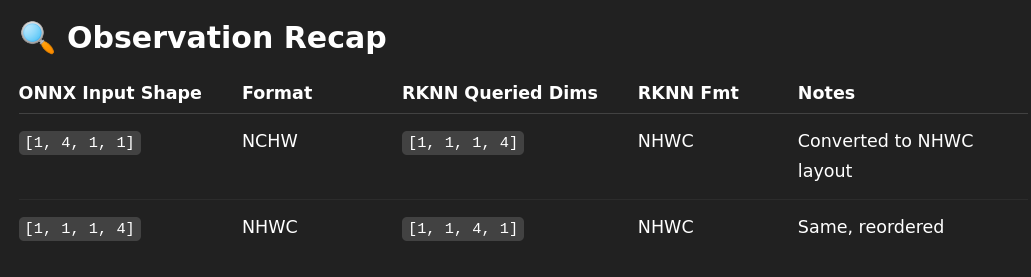